In [1]:
import pandas as pd
import re
from itertools import chain
from tqdm.auto import tqdm
from transformers import pipeline
from datasets import Dataset  # HuggingFace dataset
import numpy as np
import matplotlib.pyplot as plt
import nasdaqdatalink
import os
from dotenv import load_dotenv
load_dotenv()
API_KEY= os.getenv('API_KEY')
nasdaqdatalink.ApiConfig.api_key = API_KEY

In [96]:
truths = pd.read_parquet('data/truthsocial_trump_posts_2023-2025.parquet')


In [98]:
truths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   timestamp   10194 non-null  object
 1   header_raw  10194 non-null  object
 2   body        10194 non-null  object
dtypes: object(3)
memory usage: 239.1+ KB


In [2]:
combined = pd.read_csv('data/trump_truths_filtered.csv')
combined.rename(columns={'body_clean':'text', 'timestamp':'date'}, inplace=True)
combined['date'] = pd.to_datetime(combined['date'], format='%Y-%m-%d %H:%M:%S')
combined.drop(columns=['header_raw', 'market_related', 'body'], inplace=True)
combined.head()

,date,text
0,2025-05-17 10:27:00,Walmart should STOP trying to blame Tariffs as...
1,2025-05-09 08:43:00,"Many Trade Deals in the hopper, all good (GREA..."
2,2025-05-02 12:08:00,Maria Bartiromo: “As President Trump would say...
3,2025-04-30 09:13:00,"This is Biden’s Stock Market, not Trump’s. I d..."
4,2025-04-17 08:02:00,Had a very productive call with the President ...


In [3]:
# # Initialize sentiment analysis pipeline with FinBERT
# sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# # Apply sentiment analysis to the 'text' column
# # Using a loop with tqdm for progress bar, especially for larger datasets
# # For smaller datasets like this, direct application is also fine
# results = []
# for text in tqdm(combined['text'], desc="Analyzing sentiment"):
#     try:
#         result = sentiment_pipeline(text)
#         results.append(result[0]) # sentiment_pipeline returns a list of dicts
#     except Exception as e:
#         print(f"Error processing text: {text[:50]}... | Error: {e}")
#         results.append({'label': 'ERROR', 'score': np.nan}) # Handle potential errors

# # Convert results to DataFrame and merge
# sentiment_df = pd.DataFrame(results)
# combined['sentiment_label'] = sentiment_df['label']
# combined['sentiment_score'] = sentiment_df['score']

# # Display the first few rows with sentiment
# print(combined.head())

# # Display value counts for sentiment labels
# print("\nSentiment Label Counts:")
# print(combined['sentiment_label'].value_counts())

In [4]:
# Save to CSV
# combined.to_csv('finbert_sentiments.csv', index=False)

In [5]:
combined = pd.read_csv('data/finbert_sentiments.csv')

In [6]:
START_DATE = '2023-11-21'
END_DATE = '2025-05-17'
# Define the asset universe
tickers = {
    # US Equities
    'SPY': 'QUOTEMEDIA/PRICES',  # S&P 500 ETF
    'QQQ': 'QUOTEMEDIA/PRICES',  # Nasdaq 100 ETF
    'IWM': 'QUOTEMEDIA/PRICES',  # Russell 2000 ETF (Small Cap)
    # International Equities
    'EFA': 'QUOTEMEDIA/PRICES',  # MSCI EAFE ETF (Developed Markets ex-US/Canada)
    'EEM': 'QUOTEMEDIA/PRICES',  # MSCI Emerging Markets ETF
    # Fixed Income
    'AGG': 'QUOTEMEDIA/PRICES',  # US Aggregate Bond ETF
    'TLT': 'QUOTEMEDIA/PRICES',  # US 20+ Year Treasury Bond ETF
    # Commodities
    'GLD': 'QUOTEMEDIA/PRICES',  # Gold ETF
    'USO': 'QUOTEMEDIA/PRICES',  # Oil ETF
    # Real Estate
    'VNQ': 'QUOTEMEDIA/PRICES',   # US Real Estate ETF
    # Adding a couple more for diversity
    'GSG': 'QUOTEMEDIA/PRICES', # Broad Commodities ETF
    'HYG': 'QUOTEMEDIA/PRICES'  # High Yield Corporate Bond ETF
}


In [7]:
# Fetch data for each ticker
all_data = {}
for ticker, table in tickers.items():
    try:
        # Fetch data from the specified start_date
        data = nasdaqdatalink.get_table(
            table, 
            ticker=ticker, 
            qopts={'columns': ['date', 'adj_close']},
            date={'gte': START_DATE, 'lte': END_DATE},
            paginate=True
        )
        if not data.empty:
            data = data.set_index('date')
            all_data[ticker] = data['adj_close']
        else:
            print(f"No data found for {ticker}")
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

# Combine into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    price_df = price_df.sort_index() # Ensure dates are in ascending order
    print("\nSuccessfully fetched and combined data for all available tickers.")
    print(f"Price data from {price_df.index.min()} to {price_df.index.max()}")
else:
    print("No data was fetched. Please check ticker symbols and API key.")


Successfully fetched and combined data for all available tickers.
Price data from 2023-11-21 00:00:00 to 2025-05-16 00:00:00


In [8]:
price_df.head()

,SPY,QQQ,IWM,EFA,EEM,AGG,TLT,GLD,USO,VNQ,GSG,HYG
date,,,,,,,,,,,,
2023-11-21,448.604930,385.828290,174.823245,69.710864,38.584562,92.099566,86.782334,185.35,72.53,75.930125,21.18,70.580802
2023-11-22,450.336919,387.407477,175.919471,69.875826,38.506614,92.186361,87.089019,184.56,71.61,76.304307,20.97,70.703223
2023-11-24,450.614038,386.861218,177.104579,70.409525,38.526101,91.762028,86.063540,185.52,70.82,76.524979,20.76,70.627887
2023-11-27,449.802477,386.523530,176.512025,70.166935,38.370204,92.282800,87.501127,186.77,69.96,76.803216,20.55,70.731474
2023-11-28,450.247846,387.536593,175.830587,70.186342,38.691742,92.687845,87.673638,189.26,71.26,77.311720,20.86,71.042237


In [9]:
# Calculate daily percentage returns
returns_df = price_df.pct_change()

# Drop the first row of NaNs created by pct_change()
returns_df = returns_df.dropna(how='all')

print("Daily Stock Returns (first 5 rows):")
print(returns_df.head())

Daily Stock Returns (first 5 rows):
                 SPY       QQQ       IWM       EFA       EEM       AGG  \
date                                                                     
2023-11-22  0.003861  0.004093  0.006270  0.002366 -0.002020  0.000942   
2023-11-24  0.000615 -0.001410  0.006737  0.007638  0.000506 -0.004603   
2023-11-27 -0.001801 -0.000873 -0.003346 -0.003445 -0.004047  0.005675   
2023-11-28  0.000990  0.002621 -0.003861  0.000277  0.008380  0.004389   
2023-11-29 -0.000703 -0.000974  0.005280  0.002074 -0.005792  0.004890   

                 TLT       GLD       USO       VNQ       GSG       HYG  
date                                                                    
2023-11-22  0.003534 -0.004262 -0.012684  0.004928 -0.009915  0.001734  
2023-11-24 -0.011775  0.005202 -0.011032  0.002892 -0.010014 -0.001066  
2023-11-27  0.016704  0.006738 -0.012143  0.003636 -0.010116  0.001467  
2023-11-28  0.001972  0.013332  0.018582  0.006621  0.015085  0.004394  
2023-11

In [10]:
combined['date'] = pd.to_datetime(combined['date'])

In [11]:
import numpy as np

# Prepare sentiment data
# Create a numerical sentiment score: positive_score for positive, -negative_score for negative, 0 for neutral
combined['numeric_sentiment'] = np.select(
    [combined['sentiment_label'] == 'positive', combined['sentiment_label'] == 'negative'],
    [combined['sentiment_score'], -combined['sentiment_score']],
    default=0
)

# Ensure 'date' is just the date part, without time, for daily aggregation
combined['date_only'] = combined['date'].dt.normalize()

# Aggregate sentiment by day (mean sentiment if multiple tweets)
daily_sentiment_df = combined.groupby('date_only')['numeric_sentiment'].mean().reset_index()
daily_sentiment_df = daily_sentiment_df.set_index('date_only')
daily_sentiment_df.index.name = 'date' # Match index name for merging

print("\nDaily Aggregated Sentiment (first 5 rows):")
print(daily_sentiment_df.head())


Daily Aggregated Sentiment (first 5 rows):
            numeric_sentiment
date                         
2023-11-21           0.000000
2023-11-30           0.000000
2023-12-16           0.000000
2023-12-26           0.000000
2023-12-29          -0.886635


In [12]:
# Merge stock returns with sentiment data
# We'll do a left join on returns_df to keep all trading days
merged_df = returns_df.join(daily_sentiment_df, how='left')

# Forward-fill missing sentiment values (sentiment persists until a new tweet)
merged_df['numeric_sentiment'] = merged_df['numeric_sentiment'].fillna(method='ffill')

# Fill any remaining NaNs at the beginning (if no tweet before first trading day in range) with 0
merged_df['numeric_sentiment'] = merged_df['numeric_sentiment'].fillna(0)

print("\nMerged Data with Stock Returns and Sentiment (first 5 rows):")
print(merged_df.head())
print(f"\nShape of merged_df: {merged_df.shape}")
# Check for NaNs that might affect regression
print("\nNaNs in merged_df after processing:")
print(merged_df.isnull().sum())


Merged Data with Stock Returns and Sentiment (first 5 rows):
                 SPY       QQQ       IWM       EFA       EEM       AGG  \
date                                                                     
2023-11-22  0.003861  0.004093  0.006270  0.002366 -0.002020  0.000942   
2023-11-24  0.000615 -0.001410  0.006737  0.007638  0.000506 -0.004603   
2023-11-27 -0.001801 -0.000873 -0.003346 -0.003445 -0.004047  0.005675   
2023-11-28  0.000990  0.002621 -0.003861  0.000277  0.008380  0.004389   
2023-11-29 -0.000703 -0.000974  0.005280  0.002074 -0.005792  0.004890   

                 TLT       GLD       USO       VNQ       GSG       HYG  \
date                                                                     
2023-11-22  0.003534 -0.004262 -0.012684  0.004928 -0.009915  0.001734   
2023-11-24 -0.011775  0.005202 -0.011032  0.002892 -0.010014 -0.001066   
2023-11-27  0.016704  0.006738 -0.012143  0.003636 -0.010116  0.001467   
2023-11-28  0.001972  0.013332  0.018582  0.00662

/var/folders/b_/87z_y1k156v1lhn4cngf1jgr0000gn/T/ipykernel_64204/4031333266.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['numeric_sentiment'] = merged_df['numeric_sentiment'].fillna(method='ffill')


In [13]:
import statsmodels.api as sm

p_vals = []
betas = []
# Run regressions
# Iterate over each stock ticker column (excluding 'numeric_sentiment')
for ticker in returns_df.columns:
    print(f"\nRegression results for {ticker}:")
    
    # Define dependent (Y) and independent (X) variables
    Y = merged_df[ticker].copy()
    X = merged_df['numeric_sentiment'].copy()
    
    # Drop rows where Y is NaN (e.g., if a stock didn't trade on a particular day after initial processing)
    # This also handles cases where X might be NaN if ffill/fill(0) didn't cover everything, though it should.
    valid_data_idx = Y.notna() & X.notna()
    Y = Y[valid_data_idx]
    X = X[valid_data_idx]

    if len(Y) < 2 or len(X) < 2: # Not enough data points for regression
        print(f"Skipping {ticker} due to insufficient data after NaN removal (points: {len(Y)}).")
        continue
    if X.nunique() == 1: # Independent variable is constant
        print(f"Skipping {ticker} because sentiment score is constant for the available data.")
        continue

    # Add a constant for the intercept term
    X = sm.add_constant(X)
    
    # Fit the OLS model
    model = sm.OLS(Y, X)
    results = model.fit()

    # Store p-value and beta coefficient
    p_vals.append(results.pvalues[1])  # p-value for the sentiment coefficient
    betas.append(results.params[1])  # beta coefficient for the sentiment
    
    # Print the summary
    print(results.summary())
    print("-" * 80)



Regression results for SPY:
                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     6.011
Date:                Wed, 21 May 2025   Prob (F-statistic):             0.0147
Time:                        20:05:40   Log-Likelihood:                 1143.3
No. Observations:                 371   AIC:                            -2283.
Df Residuals:                     369   BIC:                            -2275.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const    

/var/folders/b_/87z_y1k156v1lhn4cngf1jgr0000gn/T/ipykernel_64204/2223758320.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_vals.append(results.pvalues[1])  # p-value for the sentiment coefficient
/var/folders/b_/87z_y1k156v1lhn4cngf1jgr0000gn/T/ipykernel_64204/2223758320.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas.append(results.params[1])  # beta coefficient for the sentiment
/var/folders/b_/87z_y1k156v1lhn4cngf1jgr0000gn/T/ipykernel_64204/2223758320.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as la

In [135]:
# make a DataFrame for p-values and betas with ticker
p_vals_df = pd.DataFrame({
    'Ticker': returns_df.columns,
    'P-Value': p_vals,
    'Beta': betas
})
p_vals_df.sort_values(by='P-Value', ascending=True, inplace=True)
p_vals_df

,Ticker,P-Value,Beta
0,SPY,0.0147,-0.0030
1,QQQ,0.0154,-0.0038
8,USO,0.0235,-0.0045
6,TLT,0.0266,0.0022
10,GSG,0.0408,-0.0024
5,AGG,0.0863,0.0007
2,IWM,0.1026,-0.0026
4,EEM,0.2826,-0.0013
3,EFA,0.3721,-0.0010
11,HYG,0.4053,-0.0003


# GARCH

In [15]:
!pip install arch
from arch import arch_model

<Axes: xlabel='date'>

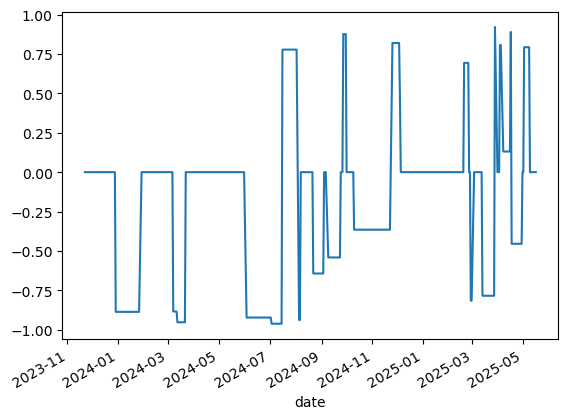

In [16]:
merged_df['numeric_sentiment'].plot()


Running GARCH(1,1) model for SPY with sentiment as exogenous variable...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -490.657
Distribution:                  Normal   AIC:                           989.314
Method:            Maximum Likelihood   BIC:                           1004.98
                                        No. Observations:                  371
Date:                Wed, May 21 2025   Df Residuals:                      370
Time:                        20:05:41   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------

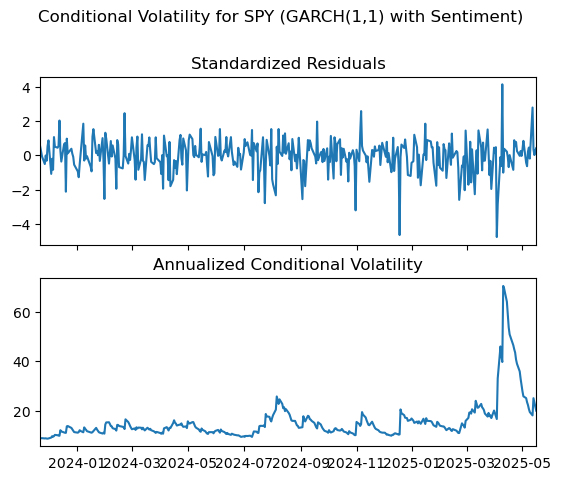

In [17]:
merged_df = merged_df.dropna()  # Ensure no NaNs for GARCH analysis

def run_garch_model(df, ticker_symbol):
    """
    Runs a GARCH(1,1) model for a given ticker with sentiment as an exogenous variable.

    Parameters:
    df (pd.DataFrame): DataFrame containing returns and 'numeric_sentiment'. 
                       Index should be datetime.
    ticker_symbol (str): The ticker symbol for which to run the GARCH model.
    """
    print(f"\nRunning GARCH(1,1) model for {ticker_symbol} with sentiment as exogenous variable...")

    # Prepare data for the chosen ticker
    # GARCH models typically work with returns (percentage change * 100 for numerical stability)
    if ticker_symbol not in df.columns:
        print(f"Ticker {ticker_symbol} not found in DataFrame columns.")
        return

    Y_garch = df[ticker_symbol].dropna() * 100 
    X_garch = df['numeric_sentiment'][Y_garch.index] # Align sentiment with available returns

    if Y_garch.empty:
        print(f"No return data available for {ticker_symbol} after processing.")
        return

    # Ensure X_garch is 2D for arch_model (if it's a Series)
    if isinstance(X_garch, pd.Series):
        X_garch = X_garch.to_frame()

    # Check for constant sentiment again, specifically for the Y_garch.index range
    if X_garch['numeric_sentiment'].nunique() == 1:
        print(f"Skipping GARCH for {ticker_symbol} because sentiment score is constant for the available data.")
        # Optionally, run GARCH without exogenous variable if sentiment is constant
        print(f"Attempting GARCH(1,1) for {ticker_symbol} without exogenous sentiment variable.")
        garch_model_no_exog = arch_model(Y_garch, vol='Garch', p=1, q=1, dist='Normal')
        try:
            garch_results_no_exog = garch_model_no_exog.fit(disp='off')
            print(garch_results_no_exog.summary())
            fig_no_exog = garch_results_no_exog.plot(annualize='D')
            plt.suptitle(f'Conditional Volatility for {ticker_symbol} (GARCH(1,1) - No Sentiment)', y=1.02)
            plt.show()
        except Exception as e:
            print(f"Could not fit GARCH model without exogenous variable for {ticker_symbol}: {e}")
        return
    
    # Define the GARCH(1,1) model
    # We include sentiment in the mean equation (x=X_garch)
    # p=1, q=1 for GARCH(1,1)
    # vol='Garch' specifies the GARCH volatility process
    # dist='Normal' assumes normally distributed errors, can try 't' for fatter tails
    garch_model = arch_model(Y_garch, x=X_garch, vol='Garch', p=1, q=1, dist='Normal')
    
    try:
        # Fit the model
        # disp='off' suppresses convergence output, can be set to 'iter' or 'final'
        garch_results = garch_model.fit(disp='off')
        
        # Print the summary
        print(garch_results.summary())
        
        # Plotting conditional volatility
        fig = garch_results.plot(annualize='D') # 'D' for daily data
        plt.suptitle(f'Conditional Volatility for {ticker_symbol} (GARCH(1,1) with Sentiment)', y=1.02)
        plt.show()
    except Exception as e:
        print(f"Could not fit GARCH model for {ticker_symbol}: {e}")

# Example usage:
# Select a ticker for GARCH analysis, e.g., SPY
run_garch_model(merged_df.copy(), 'SPY') # Use .copy() if merged_df might be modified elsewhere


Running GARCH(1,1) model for QQQ with sentiment as exogenous variable...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    QQQ   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -609.035
Distribution:                  Normal   AIC:                           1226.07
Method:            Maximum Likelihood   BIC:                           1241.74
                                        No. Observations:                  371
Date:                Wed, May 21 2025   Df Residuals:                      370
Time:                        20:05:41   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------

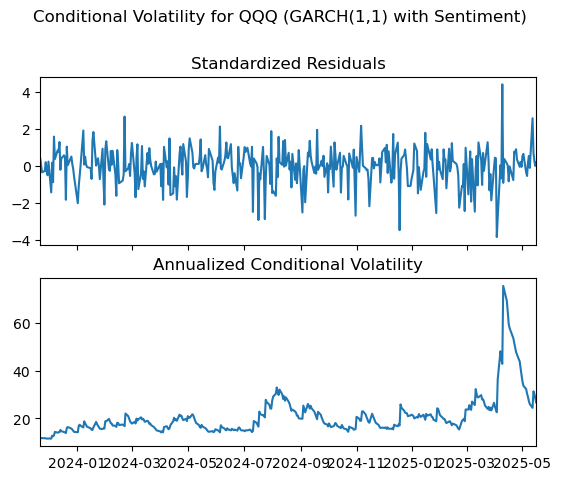

In [18]:
# Example: Run GARCH for another ticker, e.g., 'QQQ'
ticker_qqq = 'QQQ'
run_garch_model(merged_df.copy(), ticker_qqq)


Running GARCH(1,1) model for HYG with sentiment as exogenous variable...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    HYG   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -121.734
Distribution:                  Normal   AIC:                           251.467
Method:            Maximum Likelihood   BIC:                           267.132
                                        No. Observations:                  371
Date:                Wed, May 21 2025   Df Residuals:                      370
Time:                        20:05:41   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------

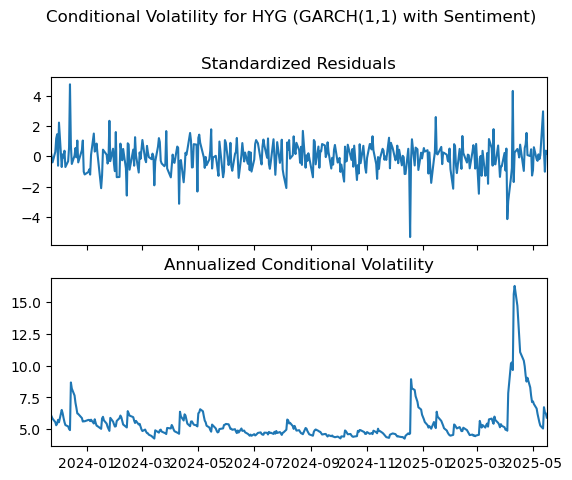

In [19]:
ticker_test = 'HYG' 
run_garch_model(merged_df.copy(), ticker_test)


Running GARCH(1,1) model for EFA with sentiment as exogenous variable...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    EFA   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -482.722
Distribution:                  Normal   AIC:                           973.444
Method:            Maximum Likelihood   BIC:                           989.109
                                        No. Observations:                  371
Date:                Wed, May 21 2025   Df Residuals:                      370
Time:                        20:05:41   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------

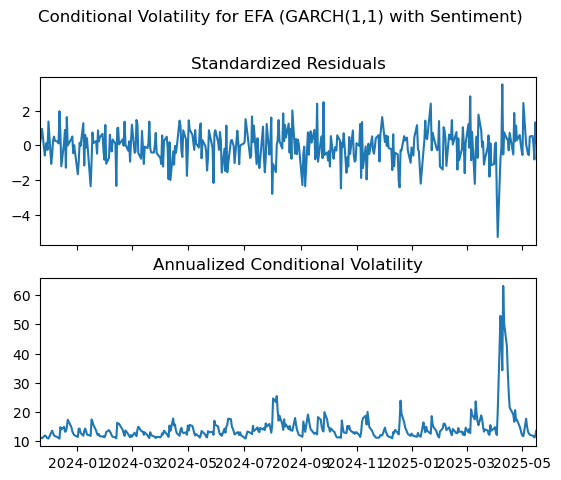

In [20]:
ticker_test = 'EFA' 
run_garch_model(merged_df.copy(), ticker_test)

In [21]:
# Example: Run GARCH for a ticker with potentially constant sentiment issues or fewer data points
# This will test the error handling and constant sentiment logic
ticker_test = '' 
run_garch_model(merged_df.copy(), ticker_test)


Running GARCH(1,1) model for  with sentiment as exogenous variable...
Ticker  not found in DataFrame columns.


# GRANGER CAUSALITY TEST

In [22]:
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd
import numpy as np

# Ensure merged_df is clean and suitable for time series analysis
# Drop rows with any NaN values that might remain, especially if returns data had NaNs
causality_df = merged_df.dropna()

max_lags = 5 # Define the maximum number of lags to test for Granger causality

granger_results_data = [] # Initialize list to store results for DataFrame

print(f"\nRunning Granger Causality Tests (max_lags={max_lags}):")
print("Null Hypothesis: Sentiment does NOT Granger-cause Stock Returns")
print("-" * 80)

for ticker in returns_df.columns:
    print(f"\nGranger Causality Test for {ticker} returns vs. Sentiment:")
    
    # Prepare data for the test: [dependent_variable (returns), independent_variable (sentiment)]
    test_data = causality_df[[ticker, 'numeric_sentiment']].copy()
    
    # Initialize values for the summary DataFrame for this ticker
    p_values_ssr_list = [np.nan] * max_lags
    p_values_params_list = [np.nan] * max_lags
    is_granger_caused_flag = False
    run_status = "OK" # Default status, will be updated if skipped or error

    # Check if there's enough data and variance
    if len(test_data) < max_lags + 5: # Heuristic for minimum data points
        print(f"Skipping {ticker} due to insufficient data points ({len(test_data)}).")
        run_status = f"Skipped: Insufficient data ({len(test_data)})"
    elif test_data['numeric_sentiment'].nunique() < 2:
        print(f"Skipping {ticker} because sentiment score is constant.")
        run_status = "Skipped: Sentiment constant"
    elif test_data[ticker].nunique() < 2:
        print(f"Skipping {ticker} because its returns are constant.")
        run_status = "Skipped: Returns constant"
    
    if run_status == "OK": # Proceed with the test only if not skipped
        try:
            # Perform the Granger causality test
            results = grangercausalitytests(test_data, maxlag=max_lags, verbose=False)
            
            # Process and print results in a more readable format
            print(f"Results for {ticker}:")
            significant_lags_found = False # Re-initialize for current ticker (as in original code)
            
            temp_p_ssr = []
            temp_p_params = []

            for lag in range(1, max_lags + 1):
                # Ensure results for the lag exist
                if lag in results and results[lag] and len(results[lag]) > 0:
                    ssr_ftest_result = results[lag][0].get('ssr_ftest')
                    params_ftest_result = results[lag][0].get('params_ftest')

                    p_value_ssr_ftest = ssr_ftest_result[1] if ssr_ftest_result else np.nan
                    p_value_params_ftest = params_ftest_result[1] if params_ftest_result else np.nan
                else:
                    p_value_ssr_ftest = np.nan
                    p_value_params_ftest = np.nan
                
                temp_p_ssr.append(p_value_ssr_ftest)
                temp_p_params.append(p_value_params_ftest)
                
                print(f"  Lag {lag}:")
                print(f"    F-test (SSR based) p-value: {p_value_ssr_ftest:.4f}")
                print(f"    F-test (params based) p-value: {p_value_params_ftest:.4f}")
                
                if (ssr_ftest_result and p_value_ssr_ftest < 0.05) or \
                   (params_ftest_result and p_value_params_ftest < 0.05):
                    significant_lags_found = True
            
            p_values_ssr_list = temp_p_ssr
            p_values_params_list = temp_p_params
            is_granger_caused_flag = significant_lags_found
            
            if significant_lags_found:
                print(f"  Conclusion for {ticker}: Potential Granger causality indicated at one or more lags (p < 0.05).")
            else:
                print(f"  Conclusion for {ticker}: No significant evidence of Granger causality found up to {max_lags} lags.")
                
        except Exception as e:
            print(f"Could not perform Granger causality test for {ticker}: {e}")
            run_status = f"Error: {str(e)}"
            # p_values lists remain NaNs, is_granger_caused_flag remains False
    
    # Append data for the current ticker
    granger_results_data.append({
        'Ticker': ticker,
        'P_Values_SSR_FTest': p_values_ssr_list,
        'P_Values_Params_FTest': p_values_params_list,
        'Is_Granger_Caused': is_granger_caused_flag,
        'Status': run_status
    })
    print("-" * 50)

# After the loop, create and display the summary DataFrame
granger_summary_df = pd.DataFrame(granger_results_data)
print("\nGranger Causality Test Summary:")
print(granger_summary_df)

# Save the DataFrame to a CSV file
granger_summary_df.to_csv('granger_causality_summary.csv', index=False)
print("\nSummary saved to granger_causality_summary.csv")


Running Granger Causality Tests (max_lags=5):
Null Hypothesis: Sentiment does NOT Granger-cause Stock Returns
--------------------------------------------------------------------------------

Granger Causality Test for SPY returns vs. Sentiment:
Results for SPY:
  Lag 1:
    F-test (SSR based) p-value: 0.0095
    F-test (params based) p-value: 0.0095
  Lag 2:
    F-test (SSR based) p-value: 0.0297
    F-test (params based) p-value: 0.0297
  Lag 3:
    F-test (SSR based) p-value: 0.0081
    F-test (params based) p-value: 0.0081
  Lag 4:
    F-test (SSR based) p-value: 0.0200
    F-test (params based) p-value: 0.0200
  Lag 5:
    F-test (SSR based) p-value: 0.0160
    F-test (params based) p-value: 0.0160
  Conclusion for SPY: Potential Granger causality indicated at one or more lags (p < 0.05).
--------------------------------------------------

Granger Causality Test for QQQ returns vs. Sentiment:
Results for QQQ:
  Lag 1:
    F-test (SSR based) p-value: 0.0158
    F-test (params base

/opt/homebrew/anaconda3/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/anaconda3/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/anaconda3/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/anaconda3/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/anaconda3/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/anaconda3/envs/q

In [104]:
granger_summary_df['p_val'] = granger_summary_df['P_Values_SSR_FTest'].apply(lambda x: x[0])
granger_summary_df[['Ticker', 'p_val', 'Is_Granger_Caused']]

,Ticker,p_val,Is_Granger_Caused
0,SPY,0.0095,True
1,QQQ,0.0158,True
2,IWM,0.0194,True
3,EFA,0.1867,False
4,EEM,0.1434,False
5,AGG,0.7235,False
6,TLT,0.3268,False
7,GLD,0.8622,False
8,USO,0.2093,True
9,VNQ,0.1793,False


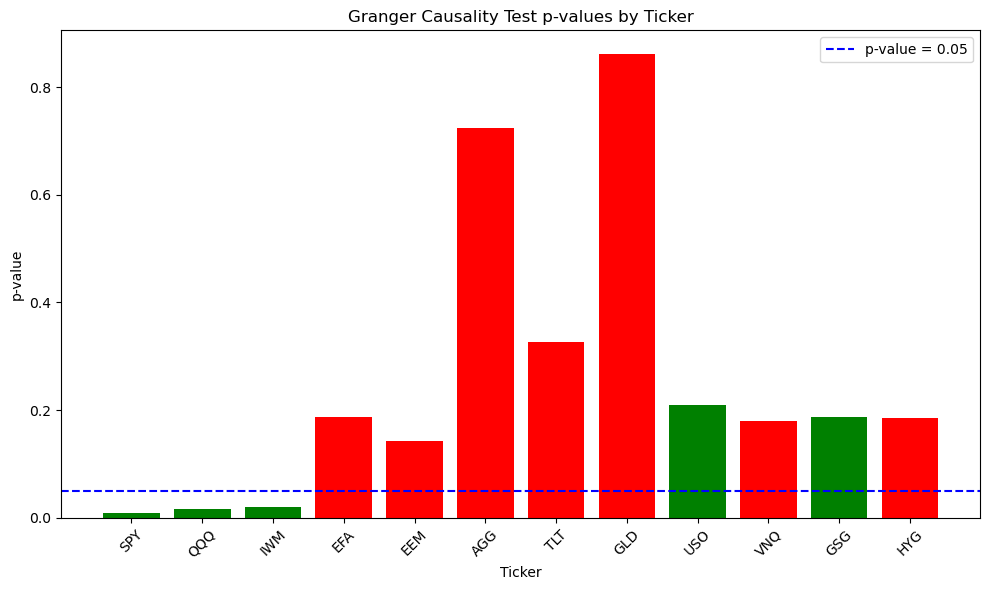

In [193]:
#bar chart of pval by ticker with True - Green and False - Red
plt.figure(figsize=(10, 6))
colors = granger_summary_df['Is_Granger_Caused'].map({True: 'green', False: 'red'})
plt.bar(granger_summary_df['Ticker'], granger_summary_df['p_val'], color=colors)
plt.axhline(y=0.05, color='blue', linestyle='--', label='p-value = 0.05')
plt.title('Granger Causality Test p-values by Ticker')
plt.xlabel('Ticker')
plt.ylabel('p-value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Portfolio Construction Test

In [159]:
from cmds import portfolio_management_helper as pmh

In [160]:
rets_df = price_df.pct_change()

In [161]:
normal_garch = pd.read_csv('data/normal_garch.csv', parse_dates=['Date'], index_col='Date')
exogenous_garch = pd.read_csv('data/exogenous_garch.csv', parse_dates=['Date'], index_col='Date')

In [162]:
exogenous_MPU_garch = pd.read_csv('data/expanding_garch_scaled_mpu_forecasts.csv', parse_dates=['Date'], index_col='Date')
exogenous_hybrid_garch = pd.read_csv('data/expanding_garch_scaled_hybrid_forecasts.csv', parse_dates=['Date'], index_col='Date')

In [163]:
normal_garch = normal_garch.dropna()
exogenous_garch = exogenous_garch.dropna()
exogenous_MPU_garch = exogenous_MPU_garch.dropna()
exogenous_hybrid_garch = exogenous_hybrid_garch.dropna()

### Exogenous Garch for entire asset universe

In [164]:
normal_portfolio_rets = pmh.calc_dynamic_tangency_weights(
    returns=rets_df,
    variances=normal_garch,
    annual_factor=252,
    cov_regularization=1,
    return_port_ret=True
)

In [165]:
exogenous_portfolio_rets = pmh.calc_dynamic_tangency_weights(
    returns=rets_df,
    variances=exogenous_garch,
    annual_factor=252,
    cov_regularization=1,
    return_port_ret=True
)

In [166]:
exogenous_MPU_rets = pmh.calc_dynamic_tangency_weights(
    returns=rets_df,
    variances=exogenous_MPU_garch,
    annual_factor=252,
    cov_regularization=1,
    return_port_ret=True
) 

In [167]:
exogenous_hybrid_rets = pmh.calc_dynamic_tangency_weights(
    returns=rets_df,
    variances=exogenous_hybrid_garch,
    annual_factor=252,
    cov_regularization=1,
    return_port_ret=True
)

In [168]:
pmh.calc_summary_statistics(normal_portfolio_rets)

Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,...,Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Tangency Weights,Recovery,Duration (days),Dynamic Tangency Portfolio Correlation
Dynamic Tangency Portfolio,0.0005,0.0058,0.0079,0.0273,0.0609,0.2110,-0.0358,0.0527,0.5313,10.9717,...,-0.0396,-0.0180,-0.0625,-0.1013,2025-02-18,2025-04-08,1.0000,2025-05-02,24,1.0000


In [169]:
pmh.calc_summary_statistics(exogenous_portfolio_rets)

Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,...,Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Tangency Weights,Recovery,Duration (days),Dynamic Tangency Portfolio Correlation
Dynamic Tangency Portfolio,0.0005,0.0058,0.0080,0.0278,0.0601,0.2081,-0.0361,0.0559,0.7423,12.4010,...,-0.0400,-0.0182,-0.0631,-0.1017,2025-02-18,2025-04-08,1.0000,2025-05-02,24,1.0000


In [170]:
pmh.calc_summary_statistics(exogenous_MPU_rets)

Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,...,Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Tangency Weights,Recovery,Duration (days),Dynamic Tangency Portfolio Correlation
Dynamic Tangency Portfolio,0.0005,0.0054,0.0077,0.0267,0.0585,0.2027,-0.0330,0.0528,0.7083,11.3625,...,-0.0389,-0.0175,-0.0606,-0.0944,2025-02-18,2025-04-08,1.0000,2025-04-29,21,1.0000


In [171]:
pmh.calc_summary_statistics(exogenous_hybrid_rets)

Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,...,Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Tangency Weights,Recovery,Duration (days),Dynamic Tangency Portfolio Correlation
Dynamic Tangency Portfolio,0.0005,0.0054,0.0079,0.0273,0.0573,0.1986,-0.0343,0.0547,0.7826,12.0448,...,-0.0397,-0.0178,-0.0617,-0.0966,2025-02-18,2025-04-08,1.0000,2025-05-02,24,1.0000


In [172]:
exogenous_cum_rets = ((1 + exogenous_portfolio_rets).cumprod() - 1) * 100
normal_cum_rets = ((1 + normal_portfolio_rets).cumprod() - 1) * 100 
exogenous_MPU_cum_rets = ((1 + exogenous_MPU_rets).cumprod() - 1) * 100
exogenous_hybrid_rets = ((1 + exogenous_hybrid_rets).cumprod() - 1) * 100


In [185]:
exogenous_cum_rets.columns = ['Exogenous Garch Sentiment']
normal_cum_rets.columns = ['Normal Garch']
exogenous_MPU_cum_rets.columns = ['Exogenous Garch MPU']
exogenous_hybrid_rets.columns = ['Exogenous Garch Hybrid']

### Constant Variance Portfolio Optimization
This section introduces a portfolio optimized using a constant variance assumption for each asset. The constant variance for each asset is derived from the mean of its historical GARCH variances.

In [186]:
# Calculate Constant Variances (mean of normal_garch for each asset)
constant_variances_df = pd.DataFrame(index=normal_garch.index, columns=normal_garch.columns)
for col in normal_garch.columns:
    constant_variances_df[col] = normal_garch[col].mean()

# Calculate portfolio returns with constant variances
constant_variance_portfolio_rets = pmh.calc_dynamic_tangency_weights(
    returns=rets_df,
    variances=constant_variances_df,
    annual_factor=252,
    cov_regularization=1, # Using 1 as per other examples, implies diagonal matrix if variances are constant
    return_port_ret=True
)
constant_variance_portfolio_rets.head()

,Dynamic Tangency Portfolio
2024-07-17,-0.0074
2024-07-18,-0.0070
2024-07-19,-0.0074
2024-07-22,0.0070
2024-07-23,-0.0006


In [187]:
pmh.calc_summary_statistics(constant_variance_portfolio_rets)

Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,...,Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Tangency Weights,Recovery,Duration (days),Dynamic Tangency Portfolio Correlation
Dynamic Tangency Portfolio,0.0004,0.0050,0.0082,0.0284,0.0513,0.1776,-0.0380,0.0604,1.0293,15.3990,...,-0.0389,-0.0183,-0.0635,-0.1028,2025-02-18,2025-04-08,1.0000,2025-05-06,28,1.0000


In [188]:
constant_variance_cum_rets = ((1 + constant_variance_portfolio_rets).cumprod() - 1) * 100

In [189]:
constant_variance_cum_rets.columns = ['Constant Variance ']
constant_variance_cum_rets.head()

,Constant Variance
2024-07-17,-0.7387
2024-07-18,-1.4373
2024-07-19,-2.1658
2024-07-22,-1.4771
2024-07-23,-1.5356


<Figure size 1200x600 with 0 Axes>

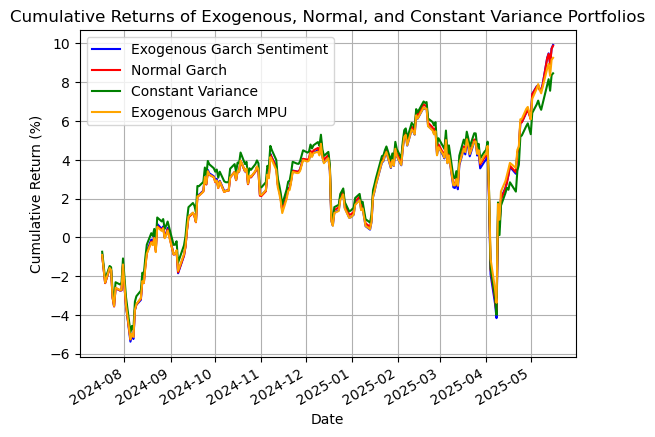

In [190]:
plt.figure(figsize=(12, 6))
ax = exogenous_cum_rets.plot(label='Exogenous Garch', color='blue')  # First plot returns the axes
normal_cum_rets.plot(ax=ax, label='Normal Garch', color='red')       # Second plot uses the same axes
constant_variance_cum_rets.plot(ax=ax, label='Constant Variance', color='green') # Add constant variance portfolio
exogenous_MPU_cum_rets.plot(ax=ax, label='Exogenous Garch MPU', color='orange') # Add Exogenous Garch MPU
plt.title('Cumulative Returns of Exogenous, Normal, and Constant Variance Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
plt.show()

In [191]:
CHART_WINDOW_SIZE = 10


<Figure size 1200x600 with 0 Axes>

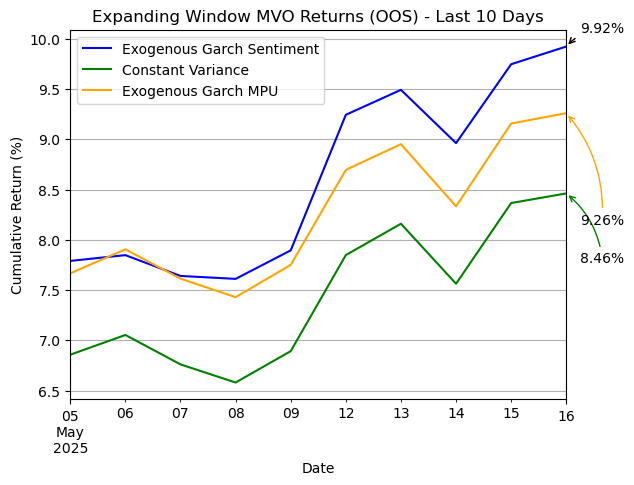

In [192]:

plt.figure(figsize=(12, 6))
ax = exogenous_cum_rets.iloc[-CHART_WINDOW_SIZE:].plot(label='Exogenous Portfolio', color='blue')
# normal_cum_rets.iloc[-CHART_WINDOW_SIZE:].plot(ax=ax, label='Normal Portfolio', color='red')
constant_variance_cum_rets.iloc[-CHART_WINDOW_SIZE:].plot(ax=ax, label='Constant Variance Portfolio', color='green')
exogenous_MPU_cum_rets.iloc[-CHART_WINDOW_SIZE:].plot(ax=ax, label='Exogenous Garch MPU', color='orange')

# Get the last values - extract scalar values with .values[0] or .item()
last_date = exogenous_cum_rets.index[-1]
last_exo_value = exogenous_cum_rets.iloc[-1].item()  # Convert to scalar
last_normal_value = normal_cum_rets.iloc[-1].item()  # Convert to scalar
last_const_var_value = constant_variance_cum_rets.iloc[-1].item() # Convert to scalar

# Annotate the last points
plt.annotate(f'{last_exo_value:.2f}%', 
             xy=(last_date, last_exo_value),
             xytext=(10, 10),  # Offset text by 10 points
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

# plt.annotate(f'{last_normal_value:.2f}%', 
#              xy=(last_date, last_normal_value),
#              xytext=(10, -20),  # Offset text by 10 points horizontally, -20 points vertically
#              textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

plt.annotate(f'{last_const_var_value:.2f}%', 
             xy=(last_date, last_const_var_value),
             xytext=(10, -50),  # Offset text
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', color='green'))
plt.annotate(f'{exogenous_MPU_cum_rets.iloc[-1].item():.2f}%',
                xy=(last_date, exogenous_MPU_cum_rets.iloc[-1].item()),
                xytext=(10, -80),  # Offset text
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', color='orange'))
plt.title('Expanding Window MVO Returns (OOS) - Last 10 Days')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show() # nothing

### Exogenous Garch for Statistically Signifigant Assets

In [74]:
asset_p_vals = pd.read_csv('garchX_sentiment_coefs.csv')
asset_p_vals = pd.DataFrame({
    'ticker': asset_p_vals.iloc[:, 0],
    'p_value_sentiment': asset_p_vals['p_value_sentiment']
})

In [75]:
not_ss_assets = asset_p_vals[asset_p_vals['p_value_sentiment'] > 0.05]
ss_assets = asset_p_vals[asset_p_vals['p_value_sentiment'] <= 0.05]

In [76]:
print("\nNot Statistically Significant Assets:")
print(list(not_ss_assets['ticker']))

print("\nStatistically Significant Assets:")
print(list(ss_assets['ticker']))


Not Statistically Significant Assets:
['SPY', 'IWM', 'AGG', 'TLT', 'USO', 'VNQ', 'IBIT']

Statistically Significant Assets:
['QQQ', 'EFA', 'EEM', 'GLD', 'GSG', 'HYG']


In [77]:
exogenous_garch_ss = exogenous_garch.copy()

In [78]:
for ticker in not_ss_assets['ticker']:
    exogenous_garch_ss[ticker] = normal_garch[ticker]

In [79]:
exogenous_ss_portfolio_rets = pmh.calc_dynamic_tangency_weights(
    returns=rets_df,
    variances=exogenous_garch_ss,
    annual_factor=252,
    cov_regularization=1,
    return_port_ret=True
)

In [80]:
pmh.calc_summary_statistics(exogenous_ss_portfolio_rets)

Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,...,Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Tangency Weights,Recovery,Duration (days),Dynamic Tangency Portfolio Correlation
Dynamic Tangency Portfolio,0.0005,0.0058,0.0080,0.0278,0.0601,0.2081,-0.0362,0.0558,0.7344,12.4402,...,-0.0398,-0.0182,-0.0630,-0.1019,2025-02-18,2025-04-08,1.0000,2025-05-02,24,1.0000


In [81]:
exogenous_ss_cum_rets = ((1 + exogenous_ss_portfolio_rets).cumprod() - 1) * 100
exogenous_ss_cum_rets.columns = ['Exogenous (Statistically Signifigant) Garch MVO Portfolio']

In [82]:
exogenous_ss_cum_rets

,Exogenous (Statistically Signifigant) Garch MVO Portfolio
2024-07-17,-0.0092
2024-07-18,-0.0163
2024-07-19,-0.0237
2024-07-22,-0.0161
2024-07-23,-0.0172
...,...
2025-05-12,0.0924
2025-05-13,0.0949
2025-05-14,0.0895
2025-05-15,0.0974


<Figure size 1200x600 with 0 Axes>

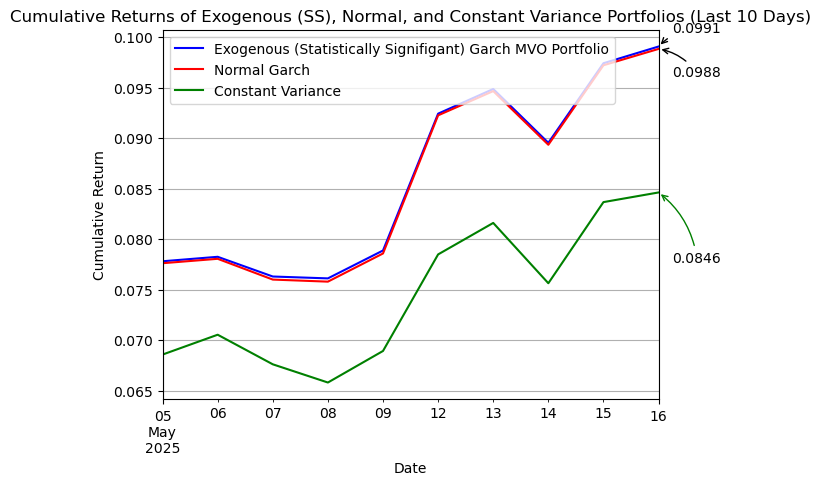

In [83]:
CHART_WINDOW_SIZE = 10

plt.figure(figsize=(12, 6))
ax = exogenous_ss_cum_rets.iloc[-CHART_WINDOW_SIZE:].plot(label='Exogenous (SS) Portfolio', color='blue')
normal_cum_rets.iloc[-CHART_WINDOW_SIZE:].plot(ax=ax, label='Normal Portfolio', color='red')
constant_variance_cum_rets.iloc[-CHART_WINDOW_SIZE:].plot(ax=ax, label='Constant Variance Portfolio', color='green')


# Get the last values - extract scalar values with .values[0] or .item()
last_date = exogenous_ss_cum_rets.index[-1]
last_exo_ss_value = exogenous_ss_cum_rets.iloc[-1].item()  # Convert to scalar
last_normal_value = normal_cum_rets.iloc[-1].item()  # Convert to scalar
last_const_var_value = constant_variance_cum_rets.iloc[-1].item() # Convert to scalar


# Annotate the last points
plt.annotate(f'{last_exo_ss_value:.2f}%', 
             xy=(last_date, last_exo_ss_value),
             xytext=(10, 10),  # Offset text by 10 points
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

plt.annotate(f'{last_normal_value:.2f}%', 
             xy=(last_date, last_normal_value),
             xytext=(10, -20),  # Offset text by 10 points horizontally, -20 points vertically
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

plt.annotate(f'{last_const_var_value:.2f}%', 
             xy=(last_date, last_const_var_value),
             xytext=(10, -50),  # Offset text
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', color='green'))

plt.title('Cumulative Returns of Exogenous (SS), Normal, and Constant Variance Portfolios (Last 10 Days)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()